In [14]:
# 필요한 라이브러리 로드
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from scipy.stats import randint


warnings.filterwarnings("ignore")


In [16]:
# SMOTE 를 이용한 Oversampling
def oversampling(data: pd.DataFrame, label: pd.DataFrame):
    smote = SMOTE(random_state=42)
    columns = data.columns.values

    x_over, y_over = smote.fit_resample(data, label)
    return pd.DataFrame(x_over, columns=columns), pd.DataFrame(y_over)

In [17]:
# 특성 선택
def feature_selection(data: pd.DataFrame, label: pd.DataFrame, model: str):
    columns = data.columns.values

    # 분류 기준이 선형인 경우
    linear_svc = LinearSVC(C=1, penalty="l1", dual=False).fit(data, label)
    logistic_classifier = LogisticRegression(random_state=0).fit(data, label)
    tree = ExtraTreesClassifier(n_estimators=100).fit(data, label)

    model_dic = {"SVC": SelectFromModel(linear_svc, prefit=True),
                 "Logistic": SelectFromModel(logistic_classifier, prefit=True),
                 "tree": SelectFromModel(tree, prefit=True)}

    selected_data = model_dic[model].transform(data)
    selected_data_transpose = selected_data.T

    features = []
    for i in range(len(selected_data_transpose)):
        for n in range(len(columns)):
            if list(selected_data_tnspose[i]) == list(data[columns[n]]):
                features.append(columns[n])
    selected_data = pd.DataFrame(selected_data, columns=features)

    return selected_data

In [18]:
def classifier(model, X,Y, test_size, max_depth=10):
    
    size = test_size 
    seed = 0
    estimators = 100
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = size, random_state = seed)

    if model == "DecisionTree":
        clf = DecisionTreeClassifier(random_state=seed)
    elif model == "Logistic":
        clf = LogisticRegression(random_state=seed)
    elif model == "RandomForest":
        clf = RandomForestClassifier(n_estimators=estimators, max_depth=max_depth, random_state=seed, bootstrap=True)
    elif model == "AdaBoost":
        clf = AdaBoostClassifier(n_estimators=estimators, random_state=seed)
    elif model == "XGBoost":
        clf = XGBClassifier(max_depth=max_depth)

    clf.fit(X_train, Y_train)
    pred = clf.predict(X_test)
    score = clf.score(X_test, Y_test)
    true_data = Y_test
    pred_data = pred
    
    return clf , pred, score, f1_score(true_data, pred)

In [19]:
# 성능 지표
def get_performance(y, pred):
    return f1_score(y, pred)

In [20]:
# 원본 데이터
raw_data = pd.read_csv("uci-secom.csv")

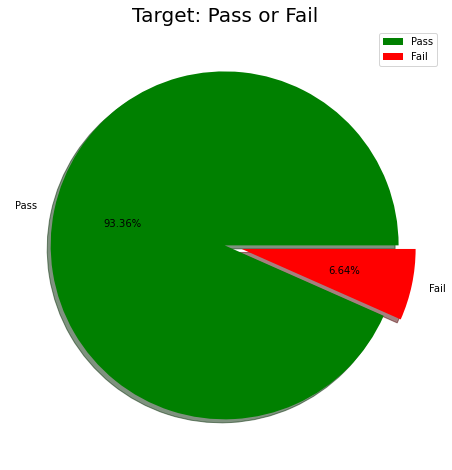

In [21]:
# 클래스 불균형 보이기
labels = ['Pass', 'Fail']
size = raw_data['Pass/Fail'].value_counts()
colors = ['green', 'red']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels=labels, colors=colors, explode=explode, autopct="%.2f%%", shadow=True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize=20)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Correlation')

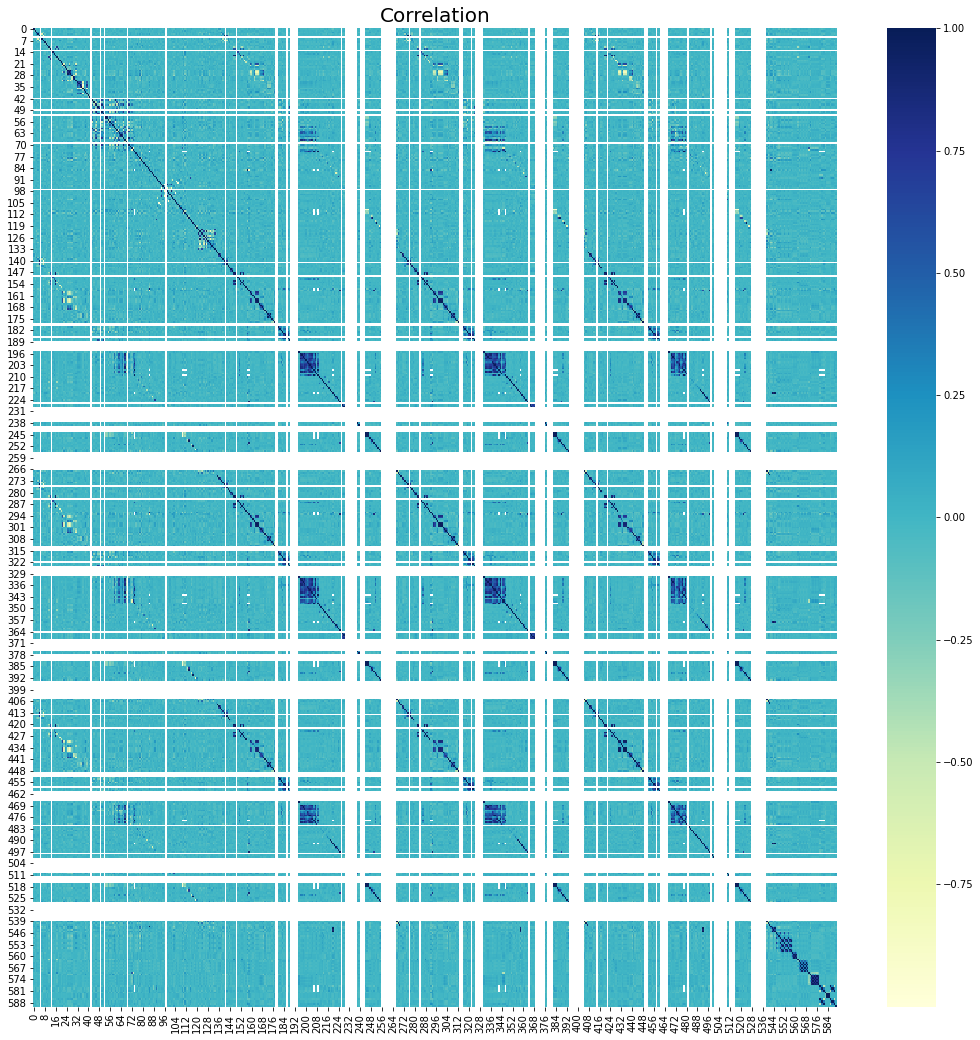

In [8]:
# 독립변수 사이의 상관 관계
plt.rcParams['figure.figsize'] = (18, 18)
sns.heatmap(raw_data.corr(), cmap="YlGnBu")
plt.title('Correlation', fontsize=20)

In [22]:
# 결측치 및 중요도가 낮은 특성 제거
# 데이터 크기 확인
data_count = raw_data.shape[0]

# 종속 변수
result = raw_data["Pass/Fail"]
# 시계열 특성 데이터라고 가정하지 않으므로 Time 속성 제거
shrunk_data = raw_data.drop(["Time"], axis=1)
shrunk_data = shrunk_data.drop(["Pass/Fail"], axis=1)

# 전체의 50% 이상이 null 값을 가진 특성 제거
shrunk_data = shrunk_data.loc[:, (raw_data.isna().sum(axis=0) <= data_count * 0.5)]

# 특성의 모든 값이 상수를 가진 특성을 제거
shrunk_data = shrunk_data.loc[:, (raw_data.var(axis=0) != 0)]

# 독립 변수끼리의 상관 관계가 높은 항목을 제거
corr_matrix = shrunk_data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

shrunk_data.drop(to_drop, axis=1, inplace=True)

In [23]:
shrunk_data.columns

Index(['0', '1', '2', '3', '4', '6', '8', '9', '10', '11',
       ...
       '564', '565', '570', '571', '572', '582', '583', '586', '587', '589'],
      dtype='object', length=201)

In [24]:
# K개의 이웃을 통해 결측치를 예측
imputer = KNNImputer(n_neighbors=5)
imputed_data = pd.DataFrame(imputer.fit_transform(shrunk_data), columns=shrunk_data.columns)


In [25]:
# Feature Selection 할 Model 선택
model_list_select = ["SVC", "Logistic", "tree"]
model_list_train = ["DecisionTree", "Logistic", "RandomForest", "AdaBoost", "XGBoost"]
for select_model in model_list_select:
    for train_model in model_list_train:
        featured_data = feature_selection(imputed_data, result, select_model)
        oversampled_x, oversampled_y = oversampling(featured_data, result)
        clf , pred, score, f1 = classifier(train_model, oversampled_x, oversampled_y, test_size=0.2)
    
        print(f"Model Selection:{select_model}/Train Model:{train_model}/F1-score:{f1}")

Model Selection:SVC/Train Model:DecisionTree/F1-score:0.8999999999999999
Model Selection:SVC/Train Model:Logistic/F1-score:0.7081850533807829
Model Selection:SVC/Train Model:RandomForest/F1-score:0.9700176366843034
Model Selection:SVC/Train Model:AdaBoost/F1-score:0.9309734513274337
[22:43:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Selection:SVC/Train Model:XGBoost/F1-score:0.9803220035778175
Model Selection:Logistic/Train Model:DecisionTree/F1-score:0.8892674616695059
Model Selection:Logistic/Train Model:Logistic/F1-score:0.7247386759581883
Model Selection:Logistic/Train Model:RandomForest/F1-score:0.9577464788732394
Model Selection:Logistic/Train Model:AdaBoost/F1-score:0.9125874125874125
[22:43:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learn

In [12]:
# 가장 좋은 Feature selection 및 모델을 기반으로 하이퍼파라미터 튜닝
featured_data = feature_selection(imputed_data, result, "SVC")
oversampled_x, oversampled_y = oversampling(featured_data, result)
x_train, x_test, y_train, y_test = train_test_split(oversampled_x, oversampled_y, test_size=0.2, random_state=0)
clf = XGBClassifier()

params = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100]}

# Create a random search object
clf = RandomizedSearchCV(clf, params, n_iter=100,
                            n_jobs=16, verbose=2, cv=2,
                            scoring='neg_log_loss', refit=True, random_state=42)
clf.fit(x_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[17:31:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:31:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                        'colsample_bytree': [0.4, 0.5, 0.6, 0.7,
                                                             0.8, 0.9, 1.0],
                       

In [13]:
pred = clf.predict(x_test)
f1_score(y_test, pred)

0.992831541218638